## 1. Import Libraries and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import time
import json

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


TensorFlow version: 2.15.0
GPU available: []


## 2. Load and Explore CIFAR-10 Dataset

In [2]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nPixel value range: [{x_train.min()}, {x_train.max()}]")
print(f"Number of classes: {len(class_names)}")

170498071/170498071 [==============================] - 910s 5us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Pixel value range: [0, 255]
Number of classes: 10


## 3. Visualize Sample Images

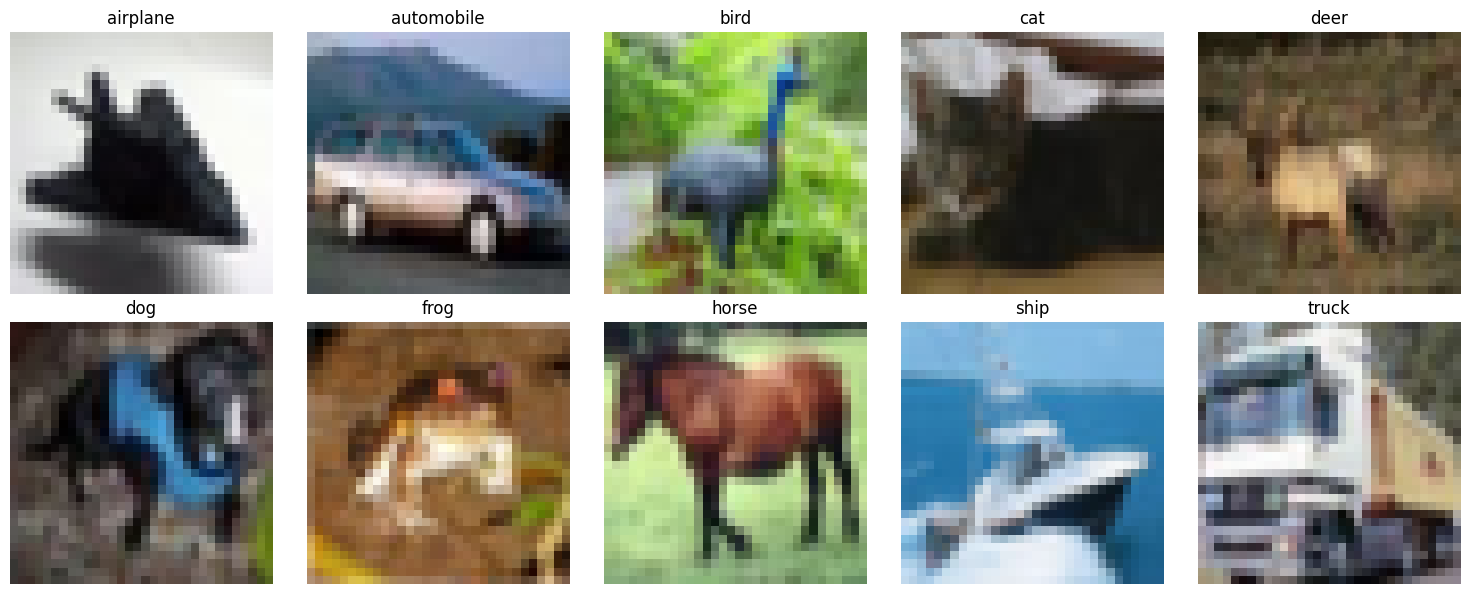

Sample images saved to output/sample_images.png


In [3]:
# Display sample images from each class
plt.figure(figsize=(15, 6))
for i in range(10):
    # Find first image of each class
    idx = np.where(y_train == i)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('output/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample images saved to output/sample_images.png")

## 4. Data Preprocessing

In [4]:
# Normalize pixel values to [0, 1]
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

# Create validation split (10% of training data)
val_size = int(0.1 * len(x_train_normalized))
x_val = x_train_normalized[:val_size]
y_val = y_train_categorical[:val_size]
x_train_final = x_train_normalized[val_size:]
y_train_final = y_train_categorical[val_size:]

print(f"Training set: {x_train_final.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test_normalized.shape[0]} samples")
print(f"\nNormalized pixel range: [{x_train_normalized.min()}, {x_train_normalized.max()}]")

Training set: 45000 samples
Validation set: 5000 samples
Test set: 10000 samples

Normalized pixel range: [0.0, 1.0]


## 5. Build CNN Model

Architecture:
- 3 Convolutional blocks (Conv2D + BatchNorm + MaxPool + Dropout)
- Dense layers with regularization
- Total parameters: ~2.3M

In [5]:
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Build a CNN model for CIFAR-10 classification.
    
    Architecture includes:
    - 3 convolutional blocks with increasing filters (64, 128, 256)
    - Batch normalization for training stability
    - Dropout for regularization
    - Dense layers with L2 regularization
    """
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                      input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build the model
model = build_cnn_model()
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 Normalization)                  

## 6. Compile Model with Optimized Hyperparameters

In [6]:
# Learning rate schedule
initial_learning_rate = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully")
print(f"Initial learning rate: {initial_learning_rate}")
print(f"Optimizer: Adam with exponential decay")

Model compiled successfully
Initial learning rate: 0.001
Optimizer: Adam with exponential decay


## 7. Setup Callbacks for Training

In [7]:
# Define callbacks
checkpoint_callback = callbacks.ModelCheckpoint(
    'models/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callback_list = [checkpoint_callback, early_stopping, reduce_lr]

print("Callbacks configured:")
print("- ModelCheckpoint: saves best model based on validation accuracy")
print("- EarlyStopping: stops training after 15 epochs without improvement")
print("- ReduceLROnPlateau: reduces learning rate when validation loss plateaus")

Callbacks configured:
- ModelCheckpoint: saves best model based on validation accuracy
- EarlyStopping: stops training after 15 epochs without improvement
- ReduceLROnPlateau: reduces learning rate when validation loss plateaus


## 8. Train the Model

In [8]:
# Training parameters
EPOCHS = 50
BATCH_SIZE = 64

print(f"Starting training...")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(x_train_final) // BATCH_SIZE}")
print("="*60)

# Train model
start_time = time.time()

history = model.fit(
    x_train_final, y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=callback_list,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTotal training time: {training_time/60:.2f} minutes")

Starting training...
Epochs: 50
Batch size: 64
Steps per epoch: 703
Epoch 1/50
Epoch 1/50




704/704 [==============================] - ETA: 0s - loss: 2.8705 - accuracy: 0.4159
Epoch 1: val_accuracy improved from -inf to 0.49740, saving model to models\best_model.keras

Epoch 1: val_accuracy improved from -inf to 0.49740, saving model to models\best_model.keras
704/704 [==============================] - 509s 712ms/step - loss: 2.8705 - accuracy: 0.4159 - val_loss: 2.2420 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 2/50
704/704 [==============================] - 509s 712ms/step - loss: 2.8705 - accuracy: 0.4159 - val_loss: 2.2420 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 2/50
704/704 [==============================] - ETA: 0s - loss: 1.7133 - accuracy: 0.6303
Epoch 2: val_accuracy improved from 0.49740 to 0.56580, saving model to models\best_model.keras

Epoch 2: val_accuracy improved from 0.49740 to 0.56580, saving model to models\best_model.keras
704/704 [=============================

## 9. Visualize Training History

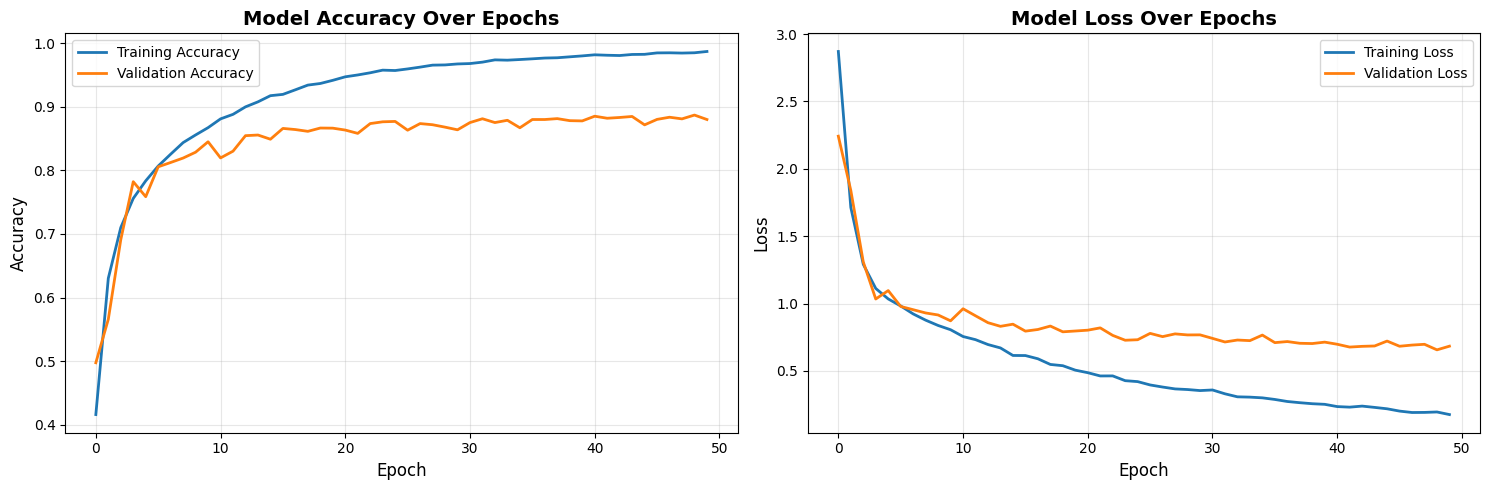


Best validation accuracy: 0.8870 at epoch 49


In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print best epoch info
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = history.history['val_accuracy'][best_epoch]
print(f"\nBest validation accuracy: {best_val_acc:.4f} at epoch {best_epoch + 1}")

## 10. Evaluate Model on Test Data

In [10]:
# Evaluate on test set
print("Evaluating model on test data...")
test_loss, test_accuracy = model.evaluate(x_test_normalized, y_test_categorical, verbose=2)

print(f"\n{'='*60}")
print(f"TEST SET RESULTS")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*60}")

Evaluating model on test data...
313/313 - 31s - loss: 0.7341 - accuracy: 0.8705 - 31s/epoch - 100ms/step

TEST SET RESULTS
Test Loss: 0.7341
Test Accuracy: 0.8705 (87.05%)
313/313 - 31s - loss: 0.7341 - accuracy: 0.8705 - 31s/epoch - 100ms/step

TEST SET RESULTS
Test Loss: 0.7341
Test Accuracy: 0.8705 (87.05%)


## 11. Generate Predictions and Detailed Metrics

In [11]:
# Generate predictions
print("Generating predictions on test set...")
y_pred_probs = model.predict(x_test_normalized)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

# Calculate comprehensive metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n{'='*60}")
print(f"PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"{'='*60}")

# Save metrics to JSON
metrics = {
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'training_time_minutes': float(training_time/60),
    'epochs_trained': len(history.history['loss']),
    'best_val_accuracy': float(best_val_acc)
}

with open('output/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print("\nMetrics saved to output/metrics.json")

Generating predictions on test set...
313/313 [==============================] - 37s 115ms/step

PERFORMANCE METRICS
Accuracy:  0.8705
Precision: 0.8715
Recall:    0.8705
F1-Score:  0.8700

Metrics saved to output/metrics.json

PERFORMANCE METRICS
Accuracy:  0.8705
Precision: 0.8715
Recall:    0.8705
F1-Score:  0.8700

Metrics saved to output/metrics.json


## 12. Classification Report by Class

In [12]:
# Detailed classification report
print("\nCLASSIFICATION REPORT BY CLASS")
print("="*80)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Save report
with open('output/classification_report.txt', 'w') as f:
    f.write(report)

print("Classification report saved to output/classification_report.txt")


CLASSIFICATION REPORT BY CLASS
              precision    recall  f1-score   support

    airplane     0.8958    0.8680    0.8817      1000
  automobile     0.9537    0.9260    0.9396      1000
        bird     0.8710    0.7560    0.8094      1000
         cat     0.7652    0.7170    0.7403      1000
        deer     0.8330    0.8830    0.8573      1000
         dog     0.7683    0.8620    0.8124      1000
        frog     0.8894    0.9250    0.9069      1000
       horse     0.9108    0.8980    0.9043      1000
        ship     0.9311    0.9330    0.9321      1000
       truck     0.8967    0.9370    0.9164      1000

    accuracy                         0.8705     10000
   macro avg     0.8715    0.8705    0.8700     10000
weighted avg     0.8715    0.8705    0.8700     10000

Classification report saved to output/classification_report.txt


## 13. Confusion Matrix Visualization

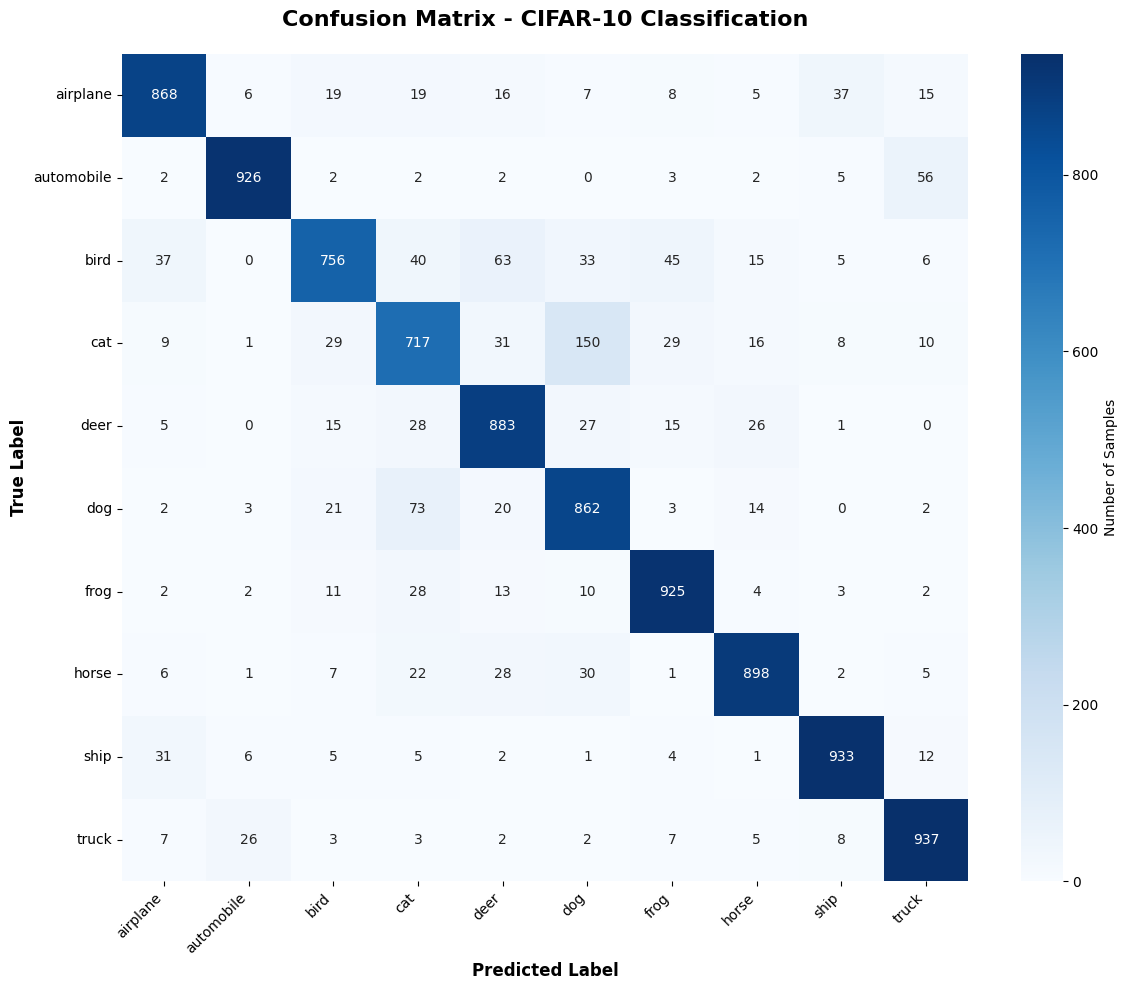

Confusion matrix saved to output/confusion_matrix.png


In [13]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})
plt.title('Confusion Matrix - CIFAR-10 Classification', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('output/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to output/confusion_matrix.png")

## 14. Per-Class Accuracy Analysis

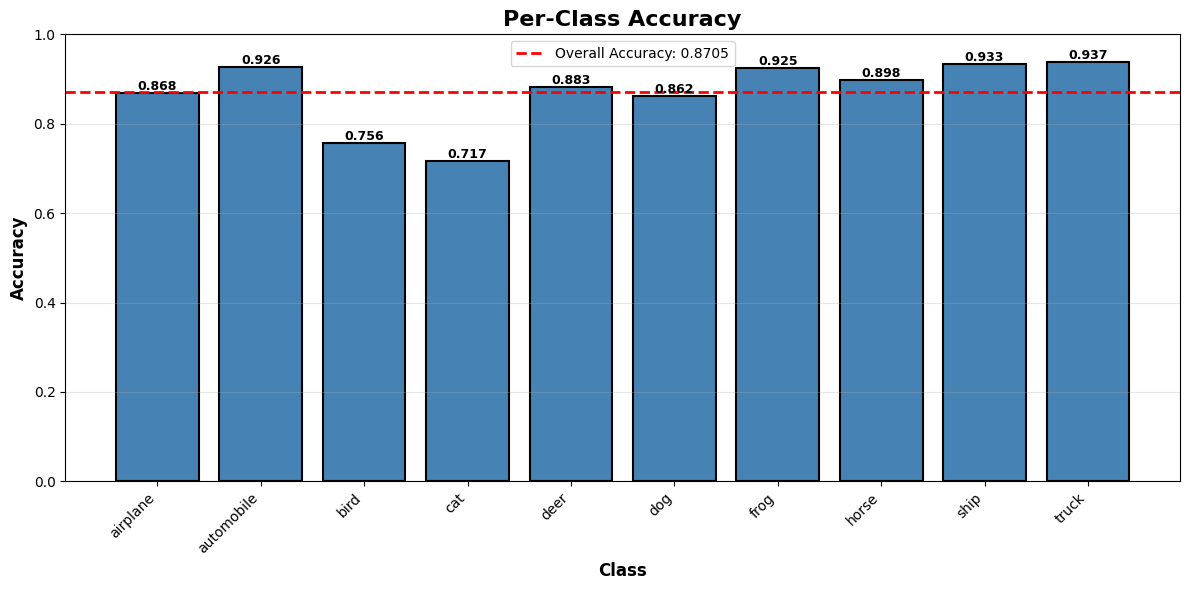


PER-CLASS ACCURACY SUMMARY
airplane    : 0.8680 (86.80%)
automobile  : 0.9260 (92.60%)
bird        : 0.7560 (75.60%)
cat         : 0.7170 (71.70%)
deer        : 0.8830 (88.30%)
dog         : 0.8620 (86.20%)
frog        : 0.9250 (92.50%)
horse       : 0.8980 (89.80%)
ship        : 0.9330 (93.30%)
truck       : 0.9370 (93.70%)
Best class:  truck (93.70%)
Worst class: cat (71.70%)


In [14]:
# Calculate per-class accuracy
class_accuracies = []
for i in range(10):
    class_mask = (y_true == i)
    class_acc = np.mean(y_pred[class_mask] == y_true[class_mask])
    class_accuracies.append(class_acc)

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracies, color='steelblue', edgecolor='black', linewidth=1.5)
plt.axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2, label=f'Overall Accuracy: {test_accuracy:.4f}')
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.ylim([0, 1])
plt.xticks(rotation=45, ha='right')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('output/per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

# Print class performance summary
print("\nPER-CLASS ACCURACY SUMMARY")
print("="*50)
for name, acc in zip(class_names, class_accuracies):
    print(f"{name:12s}: {acc:.4f} ({acc*100:.2f}%)")
print("="*50)
print(f"Best class:  {class_names[np.argmax(class_accuracies)]} ({max(class_accuracies)*100:.2f}%)")
print(f"Worst class: {class_names[np.argmin(class_accuracies)]} ({min(class_accuracies)*100:.2f}%)")

## 15. Sample Predictions Visualization

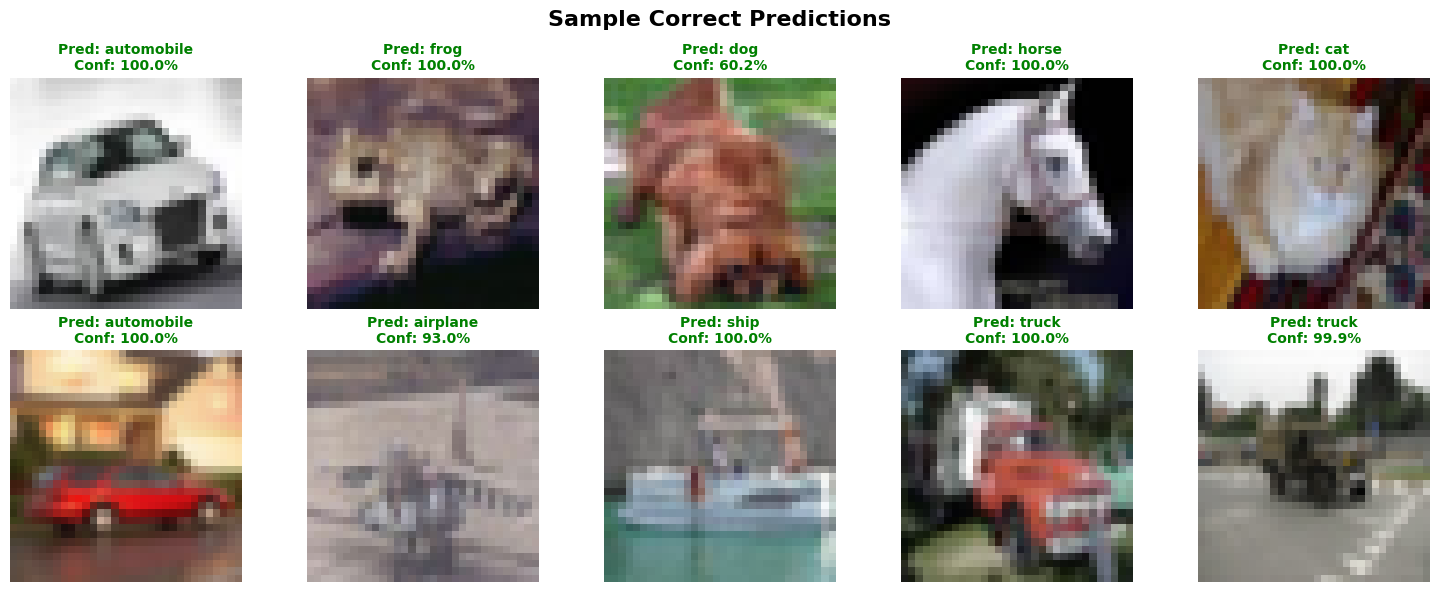

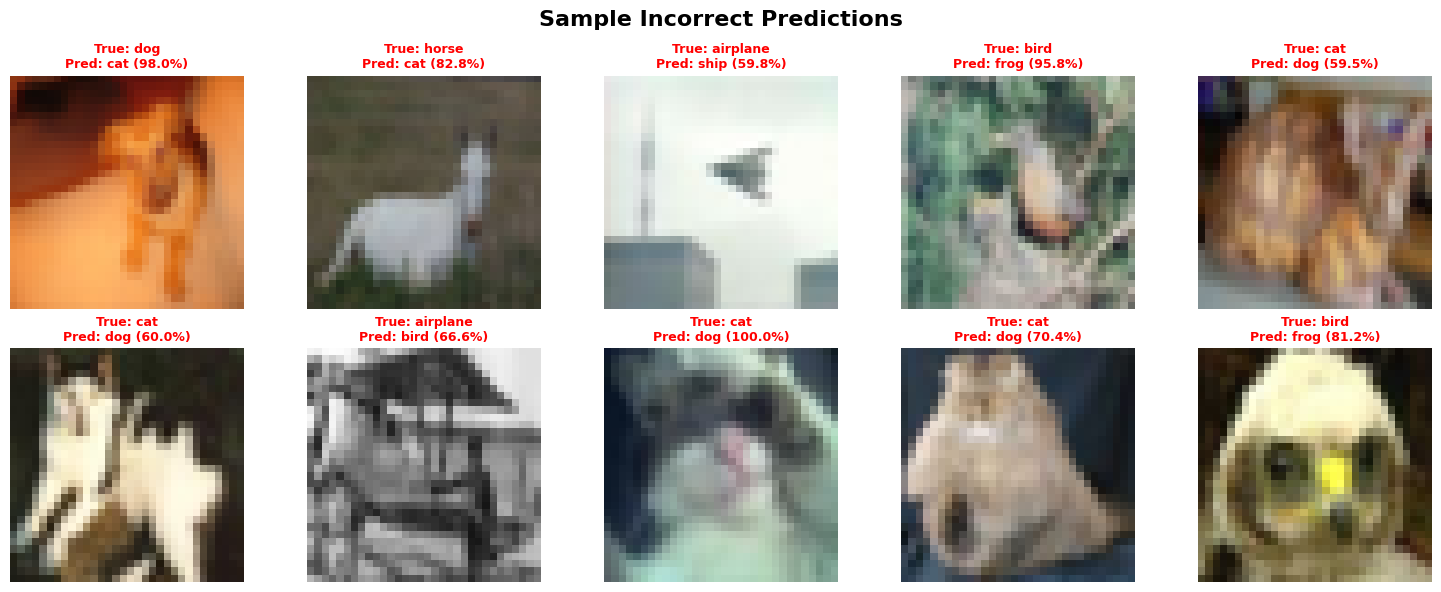


Total correct predictions: 8705 (87.05%)
Total incorrect predictions: 1295 (12.95%)


In [15]:
# Visualize correct and incorrect predictions
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

# Show some correct predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Correct Predictions', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    idx = correct_indices[np.random.randint(0, len(correct_indices))]
    ax.imshow(x_test[idx])
    pred_class = class_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]] * 100
    ax.set_title(f'Pred: {pred_class}\nConf: {confidence:.1f}%', 
                 fontsize=10, color='green', fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('output/correct_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# Show some incorrect predictions
if len(incorrect_indices) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Sample Incorrect Predictions', fontsize=16, fontweight='bold')
    
    for i, ax in enumerate(axes.flat):
        if i < len(incorrect_indices):
            idx = incorrect_indices[np.random.randint(0, len(incorrect_indices))]
            ax.imshow(x_test[idx])
            true_class = class_names[y_true[idx]]
            pred_class = class_names[y_pred[idx]]
            confidence = y_pred_probs[idx][y_pred[idx]] * 100
            ax.set_title(f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)', 
                         fontsize=9, color='red', fontweight='bold')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('output/incorrect_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

print(f"\nTotal correct predictions: {len(correct_indices)} ({len(correct_indices)/len(y_test)*100:.2f}%)")
print(f"Total incorrect predictions: {len(incorrect_indices)} ({len(incorrect_indices)/len(y_test)*100:.2f}%)")

## 16. Save Final Model

In [16]:
# Save the final model
model.save('models/final_model.keras')
print("Final model saved to models/final_model.keras")

# Summary of outputs
print("\n" + "="*60)
print("PROJECT OUTPUTS SUMMARY")
print("="*60)
print("Models saved:")
print("  - models/best_model.keras (best validation accuracy)")
print("  - models/final_model.keras (final trained model)")
print("\nVisualizations saved:")
print("  - output/sample_images.png")
print("  - output/training_history.png")
print("  - output/confusion_matrix.png")
print("  - output/per_class_accuracy.png")
print("  - output/correct_predictions.png")
print("  - output/incorrect_predictions.png")
print("\nReports saved:")
print("  - output/metrics.json")
print("  - output/classification_report.txt")
print("="*60)

Final model saved to models/final_model.keras

PROJECT OUTPUTS SUMMARY
Models saved:
  - models/best_model.keras (best validation accuracy)
  - models/final_model.keras (final trained model)

Visualizations saved:
  - output/sample_images.png
  - output/training_history.png
  - output/confusion_matrix.png
  - output/per_class_accuracy.png
  - output/correct_predictions.png
  - output/incorrect_predictions.png

Reports saved:
  - output/metrics.json
  - output/classification_report.txt
